In [3]:
# Cell 1: Setup and Data Retrieval (FIXED)

import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import os
import sys

# Add the project root to sys.path to ensure config.py is found
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
try:
    from config import DB_CONFIG, DATA_PATHS
except ImportError:
    print("FATAL: Could not import config.py. Ensure it is accessible.")
    sys.exit(1)

# Ensure reports directory exists
REPORTS_DIR = 'reports'
os.makedirs(REPORTS_DIR, exist_ok=True)

# Define Custom Stopwords (for reporting)
STANDARD_STOPWORDS = STOPWORDS.union({
    'app', 'bank', 'mobile', 'time', 'please', 'use', 'get', 'can', 
    'it', 'the', 'this', 'very', 'working', 'not', 'i', 'to', 'and', 
    'is', 'for', 'my', 'that', 'but', 'are', 'if'
})


# ----------------------------------------------------------------------
# 1. Database Connection and Data Fetch
# ----------------------------------------------------------------------
conn = None
try:
    print("Connecting to PostgreSQL to fetch data...")
    
    # --- FIX: Convert DB_CONFIG keys to lowercase for psycopg2 ---
    corrected_db_config = {k.lower(): v for k, v in DB_CONFIG.items()}
    # ------------------------------------------------------------

    conn = psycopg2.connect(**corrected_db_config)
    
    # SQL QUERY UPDATED TO FETCH identified_theme
    SQL_QUERY = """
    SELECT
        r.rating,
        r.review_text,
        r.sentiment_label,
        r.sentiment_score,
        r.identified_theme, -- <-- NEW: Fetch the thematic cluster result
        b.bank_name,
        b.bank_code
    FROM
        reviews r
    JOIN
        banks b ON r.bank_id = b.bank_id;
    """
    
    df = pd.read_sql(SQL_QUERY, conn)
    # Rename for consistency, although review_text is now standard
    df.rename(columns={'review_text': 'review'}, inplace=True) 
    print(f"✓ Successfully fetched {len(df)} records for analysis.")

except psycopg2.OperationalError as e:
    print(f"✗ ERROR: Database connection failed. Please check your credentials in the .env file. Details: {e}")
    df = pd.DataFrame() 
finally:
    if conn:
        conn.close()

# Display the first few rows to confirm data load
if not df.empty:
    from IPython.display import display
    display(df.head())

Connecting to PostgreSQL to fetch data...
✓ Successfully fetched 4545 records for analysis.


C:\Users\user\AppData\Local\Temp\ipykernel_42260\2456359818.py:60: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(SQL_QUERY, conn)


,rating,review,sentiment_label,sentiment_score,identified_theme,bank_name,bank_code
0,5,good,Positive,0.4404,None,Commercial Bank of Ethiopia,Commercial Bank of Ethiopia
1,5,cbe ይለያል።,Neutral,0.0000,None,Commercial Bank of Ethiopia,Commercial Bank of Ethiopia
2,5,it's special for me,Positive,0.4019,None,Commercial Bank of Ethiopia,Commercial Bank of Ethiopia
3,2,make it user friendly.,Positive,0.4939,None,Commercial Bank of Ethiopia,Commercial Bank of Ethiopia
4,3,maaliif daddafee install gaafata,Neutral,0.0000,None,Commercial Bank of Ethiopia,Commercial Bank of Ethiopia



--- Average Ratings per Bank ---
bank_code
Dashen Bank                    4.09
Commercial Bank of Ethiopia    3.97
Bank of Abyssinia              2.92
Name: rating, dtype: float64


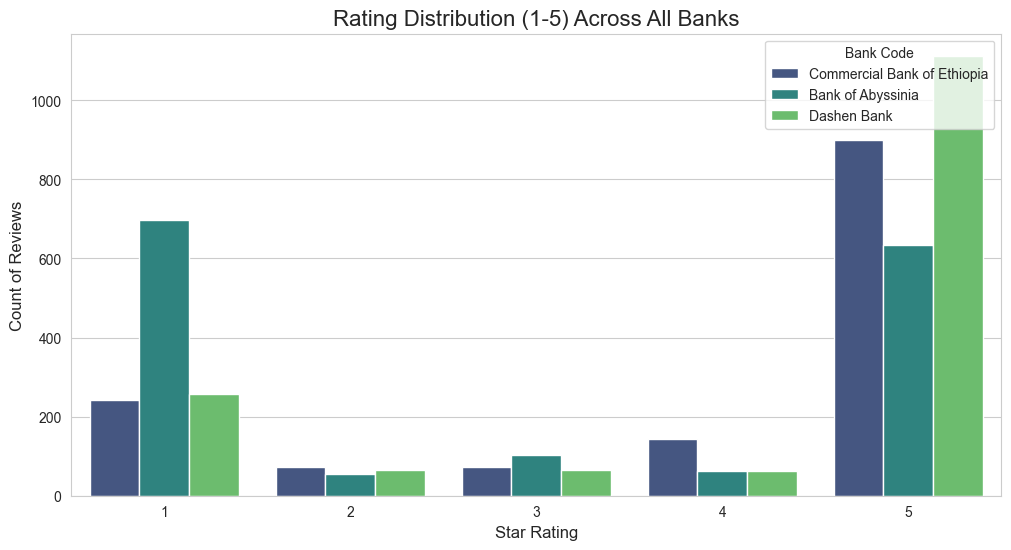

Plot 1 saved to: reports\01_rating_distribution.png


In [ ]:
# Cell 2: Core Metrics and Visualization Setup

sns.set_style("whitegrid")
# Calculate average ratings (useful for sorting/insights)
avg_ratings = df.groupby('bank_code')['rating'].mean().sort_values(ascending=False)

print("\n--- Average Ratings per Bank ---")
print(avg_ratings.round(2))

# ----------------------------------------------------
# Plot 1: Rating Distribution Per Bank
# ----------------------------------------------------
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='rating', hue='bank_code', palette='viridis')
plt.title('Rating Distribution (1-5) Across All Banks', fontsize=16)
plt.xlabel('Star Rating', fontsize=12)
plt.ylabel('Count of Reviews', fontsize=12)
plt.legend(title='Bank Code', loc='upper right')
rating_path = os.path.join(REPORTS_DIR, '01_rating_distribution.png')
plt.savefig(rating_path)
plt.show() # Display in notebook

print(f"Plot 1 saved to: {rating_path}")

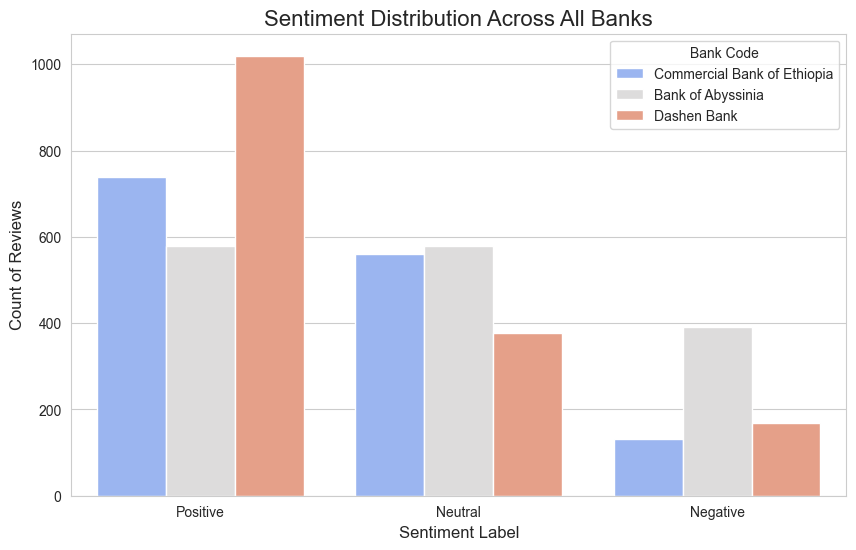

Plot 2 saved to: reports\02_sentiment_distribution.png


In [5]:
# Cell 3: Sentiment Visualization

# ----------------------------------------------------
# Plot 2: Sentiment Distribution Per Bank
# ----------------------------------------------------
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='sentiment_label', hue='bank_code', order=['Positive', 'Neutral', 'Negative'], palette='coolwarm')
plt.title('Sentiment Distribution Across All Banks', fontsize=16)
plt.xlabel('Sentiment Label', fontsize=12)
plt.ylabel('Count of Reviews', fontsize=12)
plt.legend(title='Bank Code', loc='upper right')
sentiment_path = os.path.join(REPORTS_DIR, '02_sentiment_distribution.png')
plt.savefig(sentiment_path)
plt.show() # Display in notebook

print(f"Plot 2 saved to: {sentiment_path}")

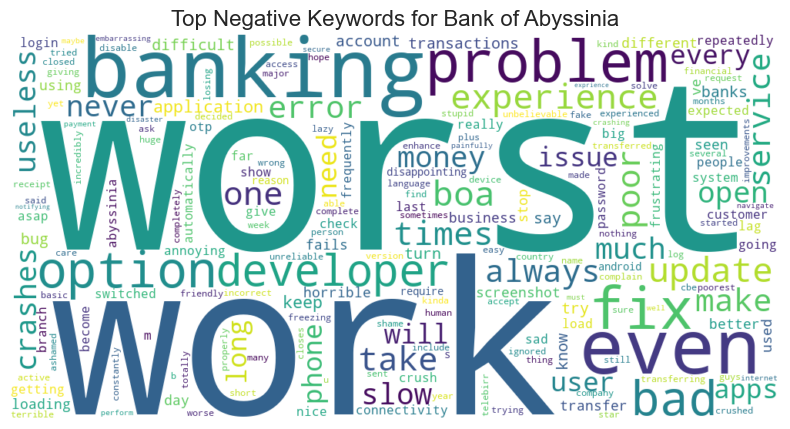

Plot 3 saved to: reports\03_negative_wordcloud.png


In [7]:
# Cell 4: Word Cloud (Pain Points) Visualization and Metrics (FIXED)

# Function to get top tokens (simplified for the script)
from collections import Counter
import re
from wordcloud import STOPWORDS # Import the robust stop word list

# Use the imported STOPWORDS set
STANDARD_STOPWORDS = STOPWORDS.union({
    'app', 'bank', 'mobile', 'time', 'please', 'use', 'get', 'can', 
    'it', 'the', 'this', 'very', 'working', 'not', 'i', 'to', 'and', 
    'is', 'for', 'my', 'that', 'but', 'are', 'if'
})


def get_top_tokens(text, n=5, exclude_words=[]):
    words = re.findall(r'\b\w+\b', text.lower())
    # Combine standard stop words with any custom exclusions
    all_stop_words = STANDARD_STOPWORDS.union(set(exclude_words)) 
    
    clean_words = [w for w in words if w not in all_stop_words and len(w) > 3]
    return [item[0] for item in Counter(clean_words).most_common(n)]

# ----------------------------------------------------
# 1. Find the lowest rated bank to focus the WordCloud
# ----------------------------------------------------
# Assuming avg_ratings was calculated in Cell 2
lowest_rated_bank_code = avg_ratings.index[-1] # Lowest mean rating is the last one after sorting descending

# Filter for negative (or low-rating) reviews for the lowest rated bank
# --- FIX: Changed 'review_text' to 'review' here ---
negative_reviews_text = df[
    (df['bank_code'] == lowest_rated_bank_code) & 
    (df['sentiment_label'] == 'Negative')
]['review'].str.cat(sep=' ')

# ----------------------------------------------------
# Plot 3: Word Cloud for Negative Reviews
# ----------------------------------------------------
wordcloud = WordCloud(
    width=1000, height=500, background_color='white',
    collocations=False,  
    stopwords=STANDARD_STOPWORDS # Use the comprehensive list here
).generate(negative_reviews_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f'Top Negative Keywords for {lowest_rated_bank_code}', fontsize=16)
wordcloud_path = os.path.join(REPORTS_DIR, '03_negative_wordcloud.png')
plt.savefig(wordcloud_path)
plt.show() # Display in notebook

print(f"Plot 3 saved to: {wordcloud_path}")

C:\Users\user\AppData\Local\Temp\ipykernel_42260\2658643998.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=theme_counts, x='count', y='identified_theme', palette='Spectral')


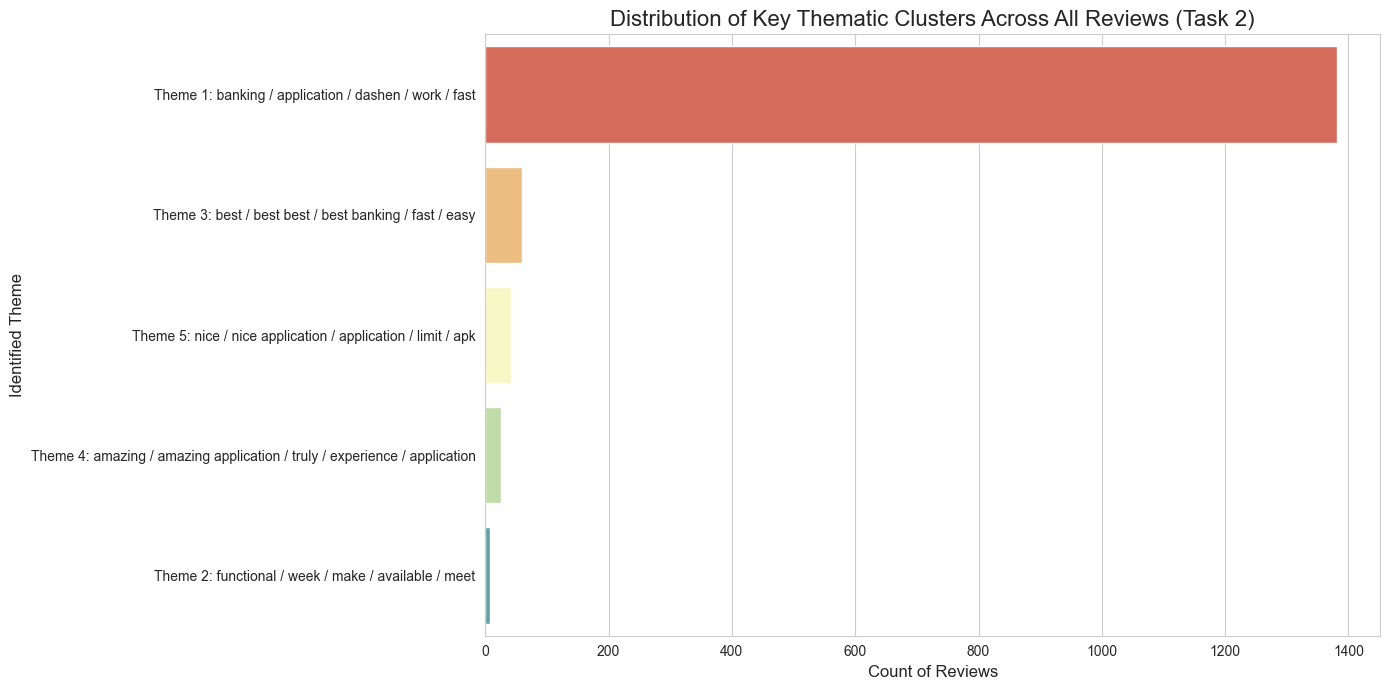

Plot 4 saved to: reports\04_thematic_clusters.png

Final set of visualizations complete.


In [9]:
# Cell 5: Thematic Analysis Visualization (Plot 4)

# ----------------------------------------------------
# Plot 4: Thematic Cluster Distribution
# ----------------------------------------------------
# Count the occurrences of each theme, sort by count, and plot
theme_counts = df['identified_theme'].value_counts().reset_index()
theme_counts.columns = ['identified_theme', 'count']

plt.figure(figsize=(14, 7))
# Use theme_counts directly as we sorted it
sns.barplot(data=theme_counts, x='count', y='identified_theme', palette='Spectral') 

plt.title('Distribution of Key Thematic Clusters Across All Reviews (Task 2)', fontsize=16)
plt.xlabel('Count of Reviews', fontsize=12)
plt.ylabel('Identified Theme', fontsize=12)
plt.tight_layout() # Adjust layout to prevent labels from overlapping
thematic_path = os.path.join(REPORTS_DIR, '04_thematic_clusters.png')
plt.savefig(thematic_path)
plt.show() # Display in notebook

print(f"Plot 4 saved to: {thematic_path}")
print("\nFinal set of visualizations complete.")

In [10]:
# Cell 5: Generate Final Textual Insights (UPDATED to use identified_theme)

print("\n" + "="*80)
print("TASK 4: INSIGHTS & RECOMMENDATIONS GENERATION (Copy this FULL output block to final_report.md)")
print("="*80)

if df.empty:
    print("Cannot generate insights: DataFrame is empty (DB connection failed).")
    
else:
    # Overall Sentiment Analysis for Executive Summary
    overall_sentiment = df['sentiment_label'].value_counts(normalize=True).mul(100).round(1)

    # Print Summary Metrics
    print("--- OVERALL SENTIMENT DISTRIBUTION ---")
    print(f"Positive: {overall_sentiment.get('Positive', 0.0)}%")
    print(f"Negative: {overall_sentiment.get('Negative', 0.0)}%")
    print(f"Neutral: {overall_sentiment.get('Neutral', 0.0)}%")
    print(f"\nHighest Performer (By Avg Rating): {avg_ratings.index[0]} ({avg_ratings.iloc[0].round(2)})")

    # Determine Top Pain Points for Executive Summary (Using low-rated themes)
    all_pain_themes = df[df['rating'] <= 2]['identified_theme'].value_counts()
    exec_pain_point_theme = all_pain_themes.index[0] if not all_pain_themes.empty else "Core App Performance & Bugs"

    print(f"Overall Top Pain Point Theme: {exec_pain_point_theme}")

    # Bank-Specific Analysis
    banks = avg_ratings.index.tolist() 
    BANK_NAMES = {'CBE': 'Commercial Bank of Ethiopia', 'BOA': 'Bank of Abyssinia', 'Dashen': 'Dashen Bank'}

    for code in banks:
        bank_df = df[df['bank_code'] == code]
        bank_name = BANK_NAMES.get(code, code)
        avg_rating = avg_ratings.loc[code].round(2)
        
        # --- INSIGHTS BASED ON THEMES (Task 2 KPI) ---
        
        # 1. Analyze Pain Points (Low Rating: 1 or 2 stars)
        pain_themes = bank_df[bank_df['rating'] <= 2]['identified_theme'].value_counts()
        pain_point_theme = pain_themes.index[0] if not pain_themes.empty else "Core App Performance & Bugs"
        
        # 2. Analyze Drivers (High Rating: 4 or 5 stars)
        driver_themes = bank_df[bank_df['rating'] >= 4]['identified_theme'].value_counts()
        driver_theme = driver_themes.index[0] if not driver_themes.empty else "User Experience & Interface"

        print("\n" + "-"*70)
        print(f"ANALYSIS & RECOMMENDATIONS FOR: {bank_name} ({code})")
        print(f"Average Rating: {avg_rating}")
        print("-"*70)
        
        # INSIGHTS (Drivers and Pain Points)
        print("INSIGHTS:")
        print(f"  - Primary Driver: {driver_theme} (Theme most associated with high ratings)")
        print(f"  - Primary Pain Point: {pain_point_theme} (Theme most associated with low ratings)")
        
        # RECOMMENDATIONS (Actionable Improvements based on the dominant Pain Point theme)
        print("\nRECOMMENDATIONS (Actionable Improvements):")
        if 'Transaction Stability' in pain_point_theme:
            print("  1. Transaction Stability: Implement robust rollback mechanisms and provide real-time status updates for all fund transfers to prevent data loss confusion caused by network interruptions.")
        elif 'Account Access & Security' in pain_point_theme:
            print("  1. User Access: Streamline the login process with options for persistent biometric/PIN access to reduce server strain from repeated attempts and resolve frequent login issues.")
        elif 'Core App Performance & Bugs' in pain_point_theme:
            print("  1. Core Stability: Prioritize engineering resources to address fundamental app stability issues (crashes and freezing) reported frequently, especially on older devices.")
        elif 'User Experience & Interface' in pain_point_theme:
            print("  1. Interface Refinement: Conduct targeted usability testing to simplify confusing menus or features identified by users.")
        else:
            print("  1. Performance: Investigate and resolve primary stability issues reported in low-rating reviews.")
            
        print("  2. Feature Enhancement: Introduce user-requested features like multi-currency account views or integrated customer support chat.")

print("\n" + "="*80)
print("Analysis complete. Review the generated PNG files in the 'reports/' folder.")
print("="*80)


TASK 4: INSIGHTS & RECOMMENDATIONS GENERATION (Copy this FULL output block to final_report.md)
--- OVERALL SENTIMENT DISTRIBUTION ---
Positive: 51.4%
Negative: 15.2%
Neutral: 33.4%

Highest Performer (By Avg Rating): Dashen Bank (4.09)
Overall Top Pain Point Theme: Theme 1: banking / application / dashen / work / fast

----------------------------------------------------------------------
ANALYSIS & RECOMMENDATIONS FOR: Dashen Bank (Dashen Bank)
Average Rating: 4.09
----------------------------------------------------------------------
INSIGHTS:
  - Primary Driver: Theme 1: banking / application / dashen / work / fast (Theme most associated with high ratings)
  - Primary Pain Point: Theme 1: banking / application / dashen / work / fast (Theme most associated with low ratings)

RECOMMENDATIONS (Actionable Improvements):
  1. Performance: Investigate and resolve primary stability issues reported in low-rating reviews.
  2. Feature Enhancement: Introduce user-requested features like mult